In [1]:
from PandasToolsFunction import *
from DataPreprocessingTools import *
import pandas as pd
from tqdm import tqdm
import json

# Formatting data

In [6]:
# Formatting train_data

data_folder_path = '../data/'

# Charger les données d'entraînement
#trainf_data = pd.read_csv(data_folder_path + 'x_train.csv')
#y_train_data = pd.read_csv(data_folder_path + 'y_train.csv')

#train_data = trainf_data
#train_data['y'] = y_train_data['y']
train_data = pd.read_csv(data_folder_path + 'train_data_vierge.csv')
train_data['date'] = pd.to_datetime(train_data['date'])

existing_column_index = train_data.columns.get_loc('date')

# Use the insert method to add the new column after the existing column
train_data.insert(existing_column_index + 1, 'day_numeric', train_data['date'].dt.day_of_week)
train_data.insert(existing_column_index + 1, 'day_name', train_data['date'].dt.day_name())


#train_data.to_csv(data_folder_path + 'train_data_with_day_of_week.csv')
#train_data = covid_remover(train_data)
#train_data.to_csv(data_folder_path + 'train_data_woCov_with_day_of_week.csv')

#after_covid_filter = make_date_filter(train_data, start_date='2021-11-01')
#train_data_after_covid = train_data[after_covid_filter]
#train_data_after_covid.to_csv('train_data_afterCov_with_day_of_week.csv')

In [7]:
train_data.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
train_data.to_csv(data_folder_path + 'train_data_day_of_week_vierge.csv', index=False)

# Right order of preprocessing : 
* Add day_types label

Not fully coded yet.
* Remove covid

-> train_data = covid_remover(train_data)
* Replicate last year (2022) to 2020.

-> train_data = replicate_one_year(train_data)

In [34]:
train_data = pd.read_csv('../data/train_data_day_of_week_vierge.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
# Add day_types label
### TO CODE ###
# Remove covid
#train_data = covid_remover(train_data)
# Replicate last year (2022) to 2020.
#train_data = replicate_one_year(train_data)

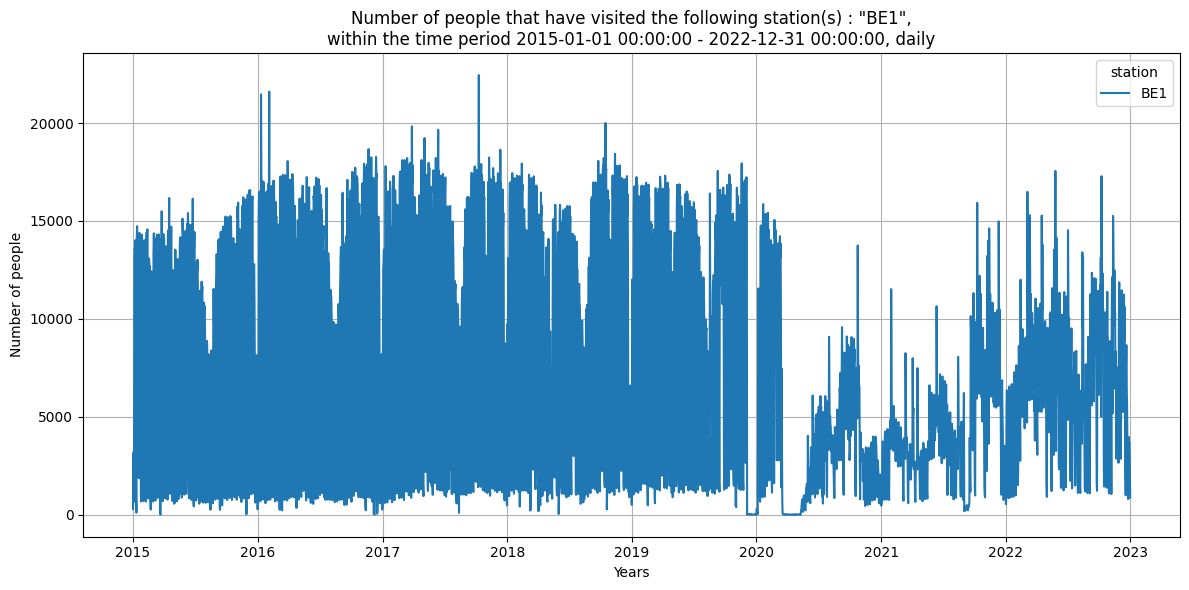

In [35]:
display = display_by_station(train_data, stations=['BE1'], display_mode='dates')

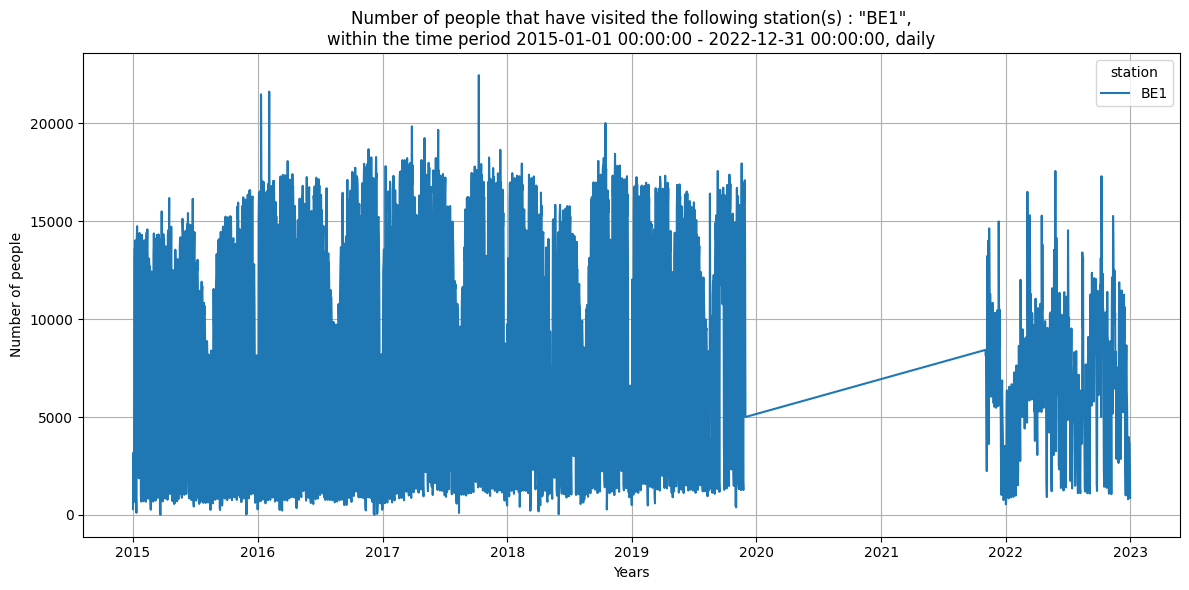

In [36]:
train_data_covid_removed = covid_remover(train_data)
display = display_by_station(train_data_covid_removed, stations=['BE1'], display_mode='dates')

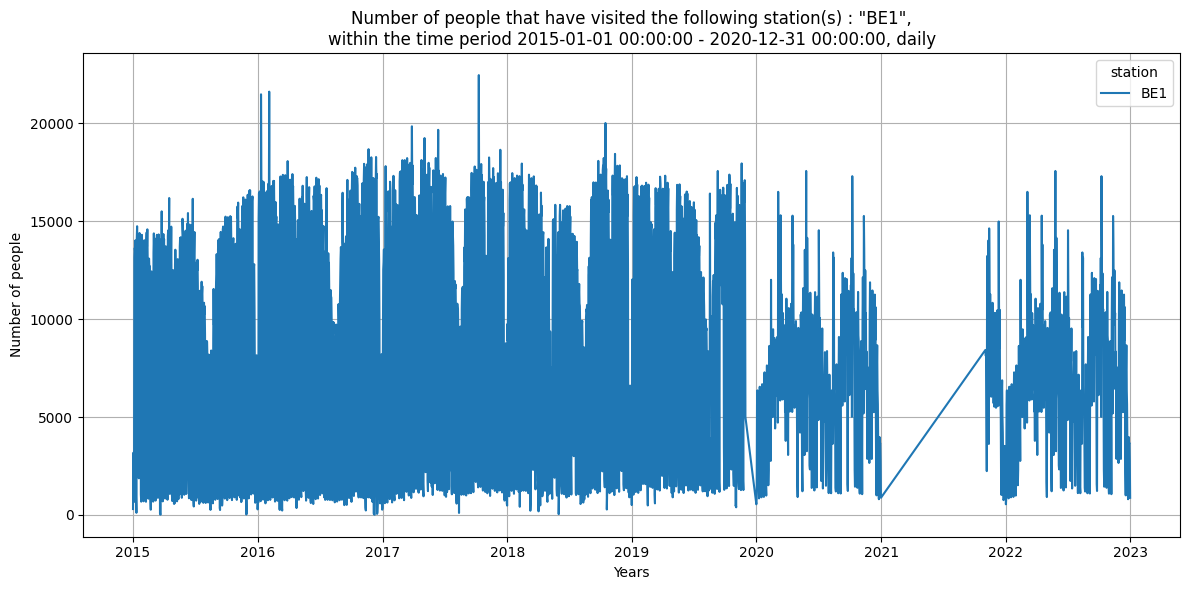

(              date   day_name  day_numeric station      y
 366     2015-01-01   Thursday            3     BE1    304
 790     2016-01-01     Friday            4     BE1    287
 1214    2017-01-01     Sunday            6     BE1    358
 1637    2018-01-01     Monday            0     BE1    481
 2063    2019-01-01    Tuesday            1     BE1    507
 ...            ...        ...          ...     ...    ...
 1097811 2020-05-31    Tuesday            1     BE1  11261
 1098220 2020-07-31     Sunday            6     BE1   1117
 1098651 2020-08-31  Wednesday            2     BE1   7620
 1099089 2020-10-31     Monday            0     BE1   3634
 1099525 2020-12-31   Saturday            5     BE1    878
 
 [2585 rows x 5 columns],
 ['BE1'])

In [37]:
covid_replaced_data = replicate_one_year(train_data_covid_removed)
display_by_station(covid_replaced_data, stations=['BE1'], display_mode='dates')

In [ ]:
def add_day_type_column(df_init: pd.DataFrame, holy_dict: dict, other_ferie: dict):
    """ 
    Here are the labels
    day_type_map = {0: 'job', 1: 'mid_holy', 2: 'start_holy', 3: 'end_holy',
                 4: 'Noel_eve', 5: 'Noel', 6: 'New_year_eve', 7: 'New_year',
                 8: 'other ferie'}
    """
    df = df_init.copy()

    df['day_type'] = 0  # Default value = JOB

    for holiday, period in holy_dict.items():
        start_date, end_date = period
        holiday_filter = make_date_filter(df, start_date, end_date)
        df.loc[holiday_filter, 'day_type'] = 1
        df.loc[holiday_filter & (df['date'] == start_date), 'day_type'] = 2  # First day
        df.loc[holiday_filter & (df['date'] == end_date), 'day_type'] = 3    # Last day
    
    for year in range(2015, 2024):
        df.loc[df['date'] == str(year) + '-12-24', 'day_type'] = 4 # Noel_eve 
        df.loc[df['date'] == str(year) + '-12-25', 'day_type'] = 5 # Noel
        df.loc[df['date'] == str(year) + '-12-31', 'day_type'] = 6 # New_year_eve
        df.loc[df['date'] == str(year) + '-01-01', 'day_type'] = 7 # New_year
    
    for ferie, period in other_ferie.items():
        pass

    return df

# Data Anomaly elimination

In [2]:
def data_anomaly_elimination(data_init: pd.DataFrame, alpha=1e-4):
    data = data_init.copy()

    elimination_counts = {}
    elimination_percentages = {}
    for station in tqdm(data['station'].unique()):
        station_count = 0

        for day_type in ['job', 'ferie', 'vacances']: # Our day types will form a partition.
            mask = (data['station'] == station) & (data[day_type] == 1)
            station_day_type_data = data[mask]

            lower_bound, upper_bound = IC(station_day_type_data['y'], alpha)

            # Keep only the data points within the confidence interval
            previous_size = len(data)
            data = data[~((mask) & ((data['y'] < lower_bound) | (data['y'] > upper_bound)))]
            
            station_count += previous_size - len(data)
        elimination_counts[station] = station_count
        elimination_percentages[station] = station_count/sum(data_init['station'] == station)

    return data, elimination_counts, elimination_percentages

In [4]:
# Charger les données d'entraînement
trainf_data = pd.read_csv('train_f_x.csv')
y_train_data = pd.read_csv('y_train_sncf.csv')

train_data = trainf_data
train_data['y'] = y_train_data['y']

In [70]:
anomaly_eliminated_data, elimination_counts, elimination_percentages = data_anomaly_elimination(train_data)

100%|██████████| 439/439 [01:55<00:00,  3.80it/s]


In [72]:

anomaly_eliminated_data.to_csv("anomaly_eliminated_train_alpha1e-4", index=False)

with open("anomaly_elimination_count_alpha1e-4", 'w') as json_file:
    json.dump(elimination_counts, json_file)

In [9]:
anomaly_eliminated_data = pd.read_csv("anomaly_eliminated_train_alpha1e-4")

# Load the dictionary from the JSON file
with open("anomaly_elimination_count_alpha1e-4", 'r') as json_file:
    elimination_counts = json.load(json_file)

In [12]:
"""max_anormal_station_idx = np.argmax(np.array(list(elimination_counts.values())))
max_anormal_station = list(elimination_counts.keys())[max_anormal_station_idx]
print(max_anormal_station)"""

max_anormal_station = max(elimination_counts, key=elimination_counts.get)

print(max_anormal_station)


B9M


Regarder les gares qui ont des grosses anomalies (en intensité et non en fréquence comme fait ci-dessus)

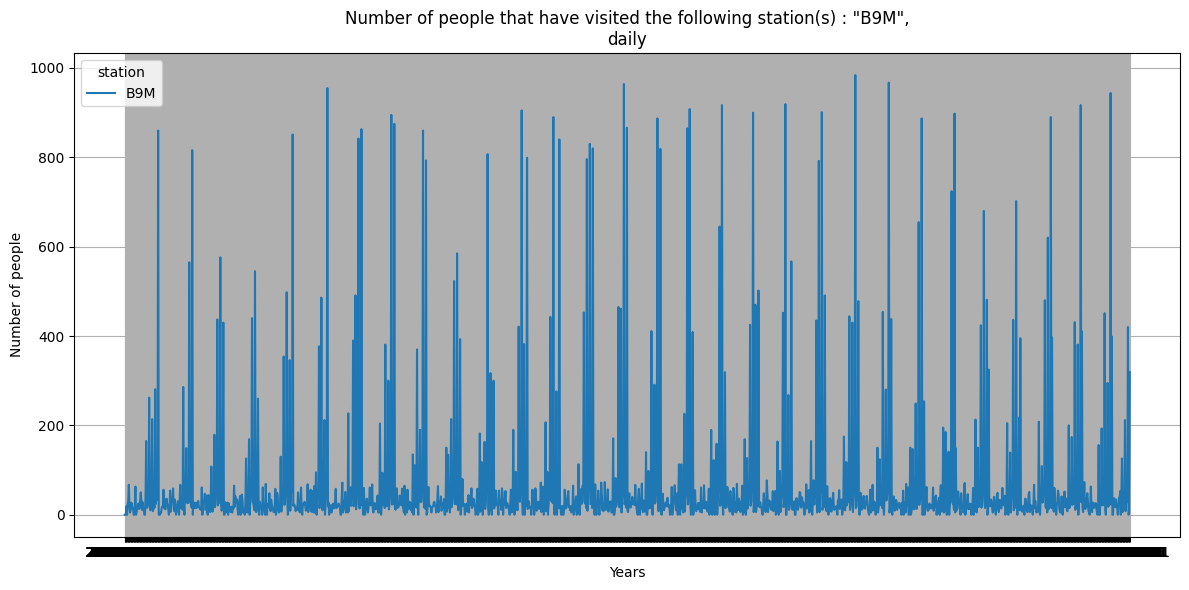

,date,station,job,ferie,vacances,y
140,2015-01-01,B9M,1,1,1,0
565,2016-01-01,B9M,1,1,1,0
990,2017-01-01,B9M,0,1,1,0
1837,2019-01-01,B9M,1,1,1,19
3453,2015-02-01,B9M,0,0,0,0
...,...,...,...,...,...,...
1224551,2018-10-31,B9M,1,0,1,29
1226226,2022-10-31,B9M,1,0,1,420
1227087,2016-12-31,B9M,0,0,1,0
1227938,2018-12-31,B9M,1,0,1,5


In [13]:
display_by_station(train_data, stations=[max_anormal_station])

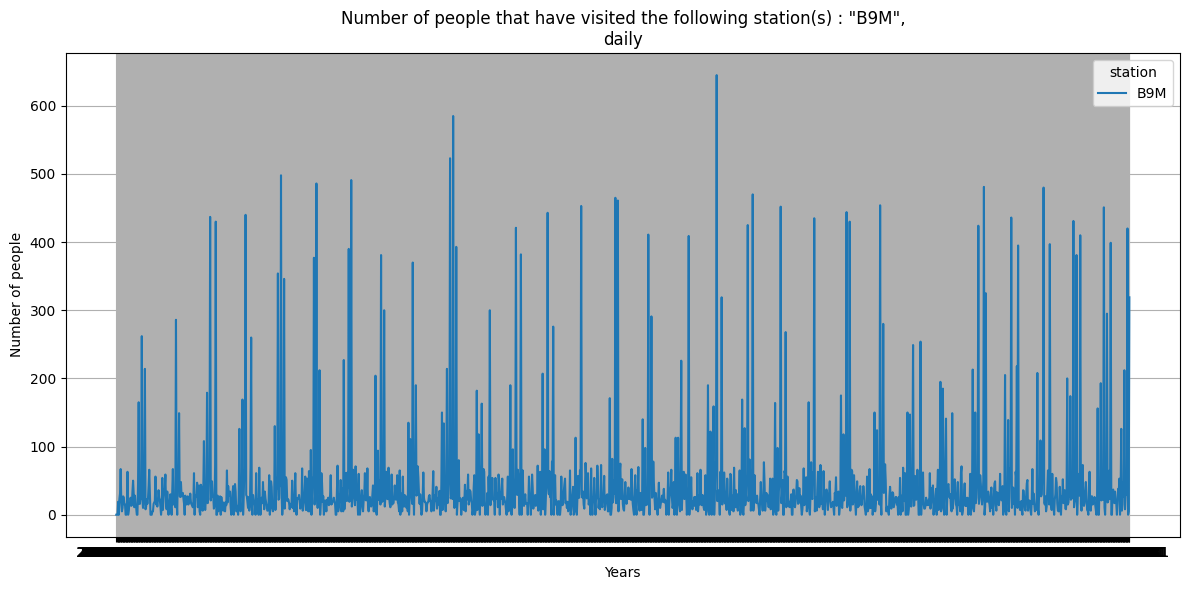

,date,station,job,ferie,vacances,y
140,2015-01-01,B9M,1,1,1,0
565,2016-01-01,B9M,1,1,1,0
990,2017-01-01,B9M,0,1,1,0
1837,2019-01-01,B9M,1,1,1,19
3453,2015-02-01,B9M,0,0,0,0
...,...,...,...,...,...,...
1224006,2018-10-31,B9M,1,0,1,29
1225681,2022-10-31,B9M,1,0,1,420
1226542,2016-12-31,B9M,0,0,1,0
1227393,2018-12-31,B9M,1,0,1,5


In [14]:
display_by_station(anomaly_eliminated_data, stations=[max_anormal_station])

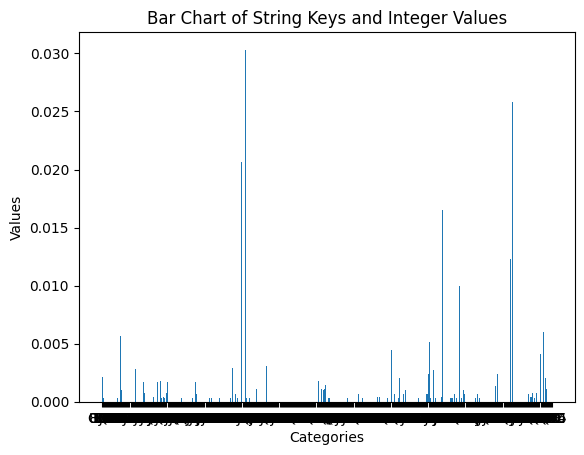

In [73]:
import matplotlib.pyplot as plt


keys = list(elimination_percentages.keys())
values = list(elimination_percentages.values())

plt.bar(keys, values)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart of String Keys and Integer Values')
plt.show()
